In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark as ps
import scipy.stats as stats
import sys
sys.path.append("..")
from src.support_functions import get_covid_data, fixing_datetime, get_zip_income, clean_up_turnstile_data

plt.style.use('ggplot')


In [2]:
data_by_zip, tests_by_day, tests_by_boro = get_covid_data()

In [3]:
data_by_zip = data_by_zip.rename(columns={"MODIFIED_ZCTA": "Zip",
                            "NEIGHBORHOOD_NAME": "Neighborhood",
                            "BOROUGH_GROUP": "Borough",
                            "COVID_CASE_COUNT": "Covid_Case_Count",
                            "COVID_CASE_RATE": "Covid_Case_Rate",
                            "POP_DENOMINATOR": "Pop_Denominator",
                            "COVID_DEATH_COUNT": "Covid_Death_Count",
                            "COVID_DEATH_RATE":"Covid_Death_Rate",
                            "PERCENT_POSITIVE":"Percent_Positive",
                            "TOTAL_COVID_TESTS": "Total_Covid_Tests"})

In [4]:
tests_by_day = tests_by_day.rename(columns={"DATE": "Date",
                             "TOTAL_TESTS": "Total_Tests",
                             "POSITIVE_TESTS": "Positive_Tests",
                             "PERCENT_POSITIVE": "Percent_Positive",
                             "TOTAL_TESTS_7DAYS_AVG": "Total_Tests_7Days_AVG",
                             "POSITIVE_TESTS_7DAYS_AVG": "Positive_Tests_7Days_AVG",
                             "PERCENT_POSITIVE_7DAYS_AVG": "Percent_Positive_7Days_AVG",
                             "INCOMPLETE": "Incomplete"})

In [5]:
tests_by_boro = tests_by_boro.rename(columns={"BOROUGH_GROUP": "Borough",
                             "CASE_RATE": "Case_Rate",
                             "HOSPITALIZED_RATE": "Hospitalized_Rate",
                             "DEATH_RATE": "Death_Rate",
                             "CASE_COUNT": "Case_Count",
                             "HOSPITALIZED_COUNT": "Hospitalized_Count",
                             "DEATH_COUNT": "Death_Count"})

In [6]:
median_income = get_zip_income()
med_income = median_income[['median_household_income', 'lat', 'lng', 'population', 'population_density']]
data = data_by_zip[['Zip', 'Neighborhood','Borough', 'Covid_Case_Count', 'Total_Covid_Tests', 'Covid_Death_Count']]
hm_covid = data.join(med_income)
hm_covid

,Zip,Neighborhood,Borough,Covid_Case_Count,Total_Covid_Tests,Covid_Death_Count,median_household_income,lat,lng,population,population_density
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,479,10193,28,81671,40.750,-73.990,21102,33959.0
1,10002,Chinatown/Lower East Side,Manhattan,1452,24932,160,33218,40.720,-73.990,81410,92573.0
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,701,25829,35,92540,40.730,-73.990,56024,97188.0
3,10004,Financial District,Manhattan,57,1350,1,129313,40.700,-74.020,3089,5519.0
4,10005,Financial District,Manhattan,120,3228,2,124670,40.705,-74.005,7135,97048.0
...,...,...,...,...,...,...,...,...,...,...,...
172,11691,Edgemere/Far Rockaway,Queens,3136,22996,379,39409,40.600,-73.760,60035,21185.0
173,11692,Arverne/Edgemere,Queens,742,6635,95,43354,40.590,-73.800,18540,18566.0
174,11693,Arverne/Broad Channel,Queens,372,3408,29,50570,40.610,-73.820,11916,11950.0
175,11694,Belle Harbor-Neponsit/Rockaway Park,Queens,833,6892,90,76944,40.580,-73.850,20408,14944.0


In [7]:
tests_by_day = fixing_datetime(tests_by_day)

In [8]:
turnstile2019_df = pd.read_csv('../data/Turnstile_Usage_Data__2019.csv', low_memory=False)
turnstile2020_df = pd.read_csv('../data/Turnstile_Usage_Data__2020.csv', low_memory=False)

In [9]:
turnstile2019_df

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,A033,R170,02-06-00,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,769115,559221
1,A033,R170,02-00-04,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,6483080,4945335
2,A033,R170,02-00-03,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,7191422,8417203
3,A033,R170,02-00-02,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,14983900,14554087
4,A033,R170,02-06-01,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,71047673,20925389
...,...,...,...,...,...,...,...,...,...,...,...
10467096,PTH02,R544,00-00-03,HARRISON,1,PTH,12/29/2018,23:57:36,REGULAR,114402,15472
10467097,PTH17,R541,01-01-02,THIRTY THIRD ST,1,PTH,12/29/2018,23:58:09,REGULAR,758475,361319
10467098,PTH04,R551,00-00-03,GROVE STREET,1,PTH,12/29/2018,23:58:55,REGULAR,8451,24664
10467099,PTH19,R549,02-02-04,NEWARK C,1,PTH,12/29/2018,23:59:03,REGULAR,26452,2129


In [10]:
ts_df_2019 = fixing_datetime(turnstile2019_df)
ts_df_2020 = fixing_datetime(turnstile2020_df)
ts_df_2019 = clean_up_turnstile_data(ts_df_2019)
ts_df_2020 = clean_up_turnstile_data(ts_df_2020)

../src/support_functions.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(["C/A", "Unit", "SCP", "Station", "Date", "Time"], inplace=True, ascending=False)
../src/support_functions.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=["C/A", "Unit", "SCP", "Station", "Date", "Time"], inplace=True)


In [11]:
gb2019 = ts_df_2019[['Station', 'SCP', 'Date', 'Entries']].groupby(['Date', 'Station', 'SCP']).agg([min, max])
gb2019.reset_index()

gb2019['Total'] = gb2019[('Entries', 'max')] - gb2019[('Entries', 'min')]
gb2019.drop(gb2019[gb2019['Total'] < 10].index, inplace=True)
gb2019.drop(gb2019[gb2019['Total'] > 10000].index, inplace=True)

sum_per_station_2019 = gb2019.groupby(level=[0, 1]).sum()

sum_per_date_2019 = sum_per_station_2019.groupby(level=[0]).sum()

sum_per_date_2019['week_avg_2019'] = sum_per_date_2019.iloc[:,2].rolling(window=7).mean()

In [12]:
gb2020 = ts_df_2020[['Station', 'SCP', 'Date', 'Entries']].groupby(['Date', 'Station', 'SCP']).agg([min, max])
gb2020.reset_index()

gb2020['Total'] = gb2020[('Entries', 'max')] - gb2020[('Entries', 'min')]
gb2020.drop(gb2020[gb2020['Total'] < 10].index, inplace=True)
gb2020.drop(gb2020[gb2020['Total'] > 10000].index, inplace=True)

sum_per_station_2020 = gb2020.groupby(level=[0, 1]).sum()

sum_per_date_2020 = sum_per_station_2020.groupby(level=[0]).sum()

sum_per_date_2020['week_avg_2020'] = sum_per_date_2020.iloc[:,2].rolling(window=7).mean()

## Hypothesis Test on MTA Usage between 2019 and 2020

H0: There was no difference in MTA Turnstile usage between March 01, 2019 thru September 30, 2019 and March 01, 2020 thru September 30, 2020.

HA: There was a difference in MTA Turnstile usage between March 01, 2019 thru September 30, 2019 and March 01, 2020 thru September 30, 2020.

Alpha: 0.05

In [13]:
stats.ttest_ind(sum_per_date_2019['week_avg_2019'].dropna(), sum_per_date_2020['week_avg_2020'].dropna(), equal_var=False )

Ttest_indResult(statistic=58.64502100753585, pvalue=1.126547666215833e-145)

***Conclusion***: Since the p-value is lower than our alpha, we reject the Null Hypothesis 
and can say there is effecient statistical evidence that there was a difference in MTA Turnstile usage between March 01, 2019 thru September 30, 2019 and March 01, 2020 thru September 30, 2020.

## 

In [14]:
sum_per_station_2020

Entries             Total
                                   min         max      
Date       Station                                      
2020-03-01 1 AV                 143577      147805  4228
           103 ST-CORONA      76436221    76445760  9539
           104 ST           1686796086  1686796517   431
           110 ST             40413160    40417505  4345
           111 ST              8060819     8061052   233
...                                ...         ...   ...
2020-09-25 WOODLAWN           32513462    32516320  2858
           WORLD TRADE CTR  1601272180  1601274889  2709
           WTC-CORTLANDT     737036711   737038454  1743
           YORK ST            29532143    29534751  2608
           ZEREGA AV           2617892     2618857   965

[74483 rows x 3 columns]

In [15]:
hm_covid

,Zip,Neighborhood,Borough,Covid_Case_Count,Total_Covid_Tests,Covid_Death_Count,median_household_income,lat,lng,population,population_density
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,479,10193,28,81671,40.750,-73.990,21102,33959.0
1,10002,Chinatown/Lower East Side,Manhattan,1452,24932,160,33218,40.720,-73.990,81410,92573.0
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,701,25829,35,92540,40.730,-73.990,56024,97188.0
3,10004,Financial District,Manhattan,57,1350,1,129313,40.700,-74.020,3089,5519.0
4,10005,Financial District,Manhattan,120,3228,2,124670,40.705,-74.005,7135,97048.0
...,...,...,...,...,...,...,...,...,...,...,...
172,11691,Edgemere/Far Rockaway,Queens,3136,22996,379,39409,40.600,-73.760,60035,21185.0
173,11692,Arverne/Edgemere,Queens,742,6635,95,43354,40.590,-73.800,18540,18566.0
174,11693,Arverne/Broad Channel,Queens,372,3408,29,50570,40.610,-73.820,11916,11950.0
175,11694,Belle Harbor-Neponsit/Rockaway Park,Queens,833,6892,90,76944,40.580,-73.850,20408,14944.0


In [16]:
subway_station_df = pd.read_csv('../data/Subway_Stations.csv')

In [17]:
subway_station_df

,URL,OBJECTID,NAME,the_geom,LINE,NOTES
0,http://web.mta.info/nyct/service/,1,Astor Pl,POINT (-73.99106999861966 40.73005400028978),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."
1,http://web.mta.info/nyct/service/,2,Canal St,POINT (-74.00019299927328 40.71880300107709),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s..."
2,http://web.mta.info/nyct/service/,3,50th St,POINT (-73.98384899986625 40.76172799961419),1-2,"1-all times, 2-nights"
3,http://web.mta.info/nyct/service/,4,Bergen St,POINT (-73.97499915116808 40.68086213682956),2-3-4,"4-nights, 3-all other times, 2-all times"
4,http://web.mta.info/nyct/service/,5,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568),3-4,"4-nights, 3-all other times"
...,...,...,...,...,...,...
468,http://web.mta.info/nyct/service/,469,Coney Island - Stillwell Av,POINT (-73.9812359981396 40.57728100006751),D-F-N-Q,"D,F,N,Q-all times"
469,http://web.mta.info/nyct/service/,470,34th St - Hudson Yards,POINT (-74.00219709442206 40.75544635961596),7-7 Express,"7-all times, 7 Express-rush hours AM westbound..."
470,http://web.mta.info/nyct/service/,641,72nd St,POINT (-73.95836178682246 40.76880251014895),Q,Q-all times
471,http://web.mta.info/nyct/service/,642,86th St,POINT (-73.95177090964917 40.77786104333163),Q,Q-all times


## Hypothesis Test on Covid-19 Tests given ratio vs Median Income

***H0***: There is no difference in the testing rate given and median household incomes.

***HA***: There is a difference in the testing rate given and median household incomes.

***Alpha***: 0.05

In [19]:
hm_covid

,Zip,Neighborhood,Borough,Covid_Case_Count,Total_Covid_Tests,Covid_Death_Count,median_household_income,lat,lng,population,population_density
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,479,10193,28,81671,40.750,-73.990,21102,33959.0
1,10002,Chinatown/Lower East Side,Manhattan,1452,24932,160,33218,40.720,-73.990,81410,92573.0
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,701,25829,35,92540,40.730,-73.990,56024,97188.0
3,10004,Financial District,Manhattan,57,1350,1,129313,40.700,-74.020,3089,5519.0
4,10005,Financial District,Manhattan,120,3228,2,124670,40.705,-74.005,7135,97048.0
...,...,...,...,...,...,...,...,...,...,...,...
172,11691,Edgemere/Far Rockaway,Queens,3136,22996,379,39409,40.600,-73.760,60035,21185.0
173,11692,Arverne/Edgemere,Queens,742,6635,95,43354,40.590,-73.800,18540,18566.0
174,11693,Arverne/Broad Channel,Queens,372,3408,29,50570,40.610,-73.820,11916,11950.0
175,11694,Belle Harbor-Neponsit/Rockaway Park,Queens,833,6892,90,76944,40.580,-73.850,20408,14944.0


In [20]:
hm_covid['tests_per_capita'] = hm_covid['Total_Covid_Tests'] / hm_covid['population']

In [24]:
tests = hm_covid.sort_values('median_household_income')

In [30]:
tests_upper = tests[tests['median_household_income'] >= tests['median_household_income'].median()]

In [31]:
tests_lower = tests[tests['median_household_income'] < tests['median_household_income'].median()]

In [32]:
tests_upper

,Zip,Neighborhood,Borough,Covid_Case_Count,Total_Covid_Tests,Covid_Death_Count,median_household_income,lat,lng,population,population_density,tests_per_capita
44,10301,Silver Lake/St. George,Staten Island,1453,13536,108,56848,40.630,-74.100,39706,10852.0,0.340906
147,11378,Maspeth,Queens,897,10548,74,57474,40.730,-73.910,34981,13697.0,0.301535
86,11105,Ditmars Steinway,Queens,651,11827,44,57525,40.780,-73.910,36688,22481.0,0.322367
74,10469,Allerton/Baychester/Pelham Gardens/Williamsbridge,Bronx,3378,25107,373,57776,40.870,-73.850,66631,26903.0,0.376807
96,11209,Bay Ridge/Fort Hamilton,Brooklyn,1496,21907,119,58261,40.620,-74.030,68853,31845.0,0.318171
...,...,...,...,...,...,...,...,...,...,...,...,...
3,10004,Financial District,Manhattan,57,1350,1,129313,40.700,-74.020,3089,5519.0,0.437035
42,10280,Battery Park City,Manhattan,69,2732,0,129574,40.707,-74.017,7853,56710.0,0.347893
39,10069,Lincoln Square,Manhattan,84,2799,2,170630,40.778,-73.988,5199,49908.0,0.538373
6,10007,TriBeCa,Manhattan,90,3202,3,216037,40.714,-74.008,6988,42751.0,0.458214


In [46]:
stats.ttest_ind(tests_lower['tests_per_capita'].dropna(), tests_upper['tests_per_capita'].dropna(), equal_var=False )

Ttest_indResult(statistic=-3.899619041531324, pvalue=0.000147828911044537)

***Conclusion***: Since the p-value is lower than our alpha, we can reject the Null Hypothesis and say that there is a difference in the testing rate given and median household incomes.

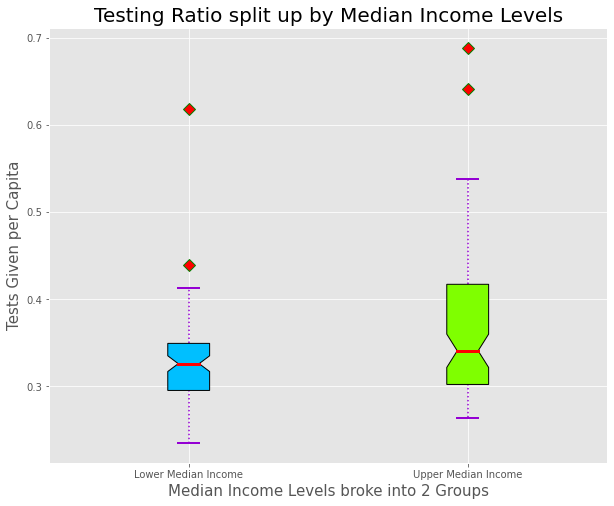

In [97]:
fig, ax = plt.subplots(figsize=(10,8))

data = [tests_lower['tests_per_capita'], tests_upper['tests_per_capita']]

flierprops = dict(marker='D', markerfacecolor='r', markersize=8,
              linestyle='none', markeredgecolor='g')
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True, notch='True', vert=1, flierprops=flierprops)

colors = ['deepskyblue', 'chartreuse'] 
  
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 

# changing color and linewidth of whiskers 
for whisker in bp['whiskers']: 
    whisker.set(color ='darkviolet', 
                linewidth = 1.5, 
                linestyle =":") 
    
for cap in bp['caps']: 
    cap.set(color ='darkviolet', 
            linewidth = 2) 

for median in bp['medians']: 
    median.set(color ='red', 
               linewidth = 3) 

    
ax.set_title('Testing Ratio split up by Median Income Levels', fontsize=20)
ax.set_ylabel('Tests Given per Capita', fontsize=15)
ax.set_xlabel('Median Income Levels broke into 2 Groups', fontsize=15)
ax.set_xticklabels(['Lower Median Income', 'Upper Median Income'])


ax.get_xaxis().tick_bottom() 
ax.get_yaxis().tick_left()

plt.savefig('../img/test_ratio_boxplot',  dpi=300)

In [ ]:
#boxplot 

## Hypothesis Test on Covid-19 Case Count vs Median Income

***H0***: There is no difference in the COVID-19 case count ratio and median household incomes.

***HA***: There is a difference in the COVID-19 case count ratio and median household incomes.

***Alpha***: 0.05

In [41]:
hm_covid.head()

,Zip,Neighborhood,Borough,Covid_Case_Count,Total_Covid_Tests,Covid_Death_Count,median_household_income,lat,lng,population,population_density,tests_per_capita,cases_per_capita
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,479,10193,28,81671,40.750,-73.990,21102,33959.0,0.483035,0.022699
1,10002,Chinatown/Lower East Side,Manhattan,1452,24932,160,33218,40.720,-73.990,81410,92573.0,0.306252,0.017836
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,701,25829,35,92540,40.730,-73.990,56024,97188.0,0.461035,0.012512
3,10004,Financial District,Manhattan,57,1350,1,129313,40.700,-74.020,3089,5519.0,0.437035,0.018453
4,10005,Financial District,Manhattan,120,3228,2,124670,40.705,-74.005,7135,97048.0,0.452418,0.016819


In [35]:
hm_covid['cases_per_capita'] = hm_covid['Covid_Case_Count'] / hm_covid['population']

In [40]:
hm_covid.head()

,Zip,Neighborhood,Borough,Covid_Case_Count,Total_Covid_Tests,Covid_Death_Count,median_household_income,lat,lng,population,population_density,tests_per_capita,cases_per_capita
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,479,10193,28,81671,40.750,-73.990,21102,33959.0,0.483035,0.022699
1,10002,Chinatown/Lower East Side,Manhattan,1452,24932,160,33218,40.720,-73.990,81410,92573.0,0.306252,0.017836
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,701,25829,35,92540,40.730,-73.990,56024,97188.0,0.461035,0.012512
3,10004,Financial District,Manhattan,57,1350,1,129313,40.700,-74.020,3089,5519.0,0.437035,0.018453
4,10005,Financial District,Manhattan,120,3228,2,124670,40.705,-74.005,7135,97048.0,0.452418,0.016819


In [37]:
cases = hm_covid.sort_values('median_household_income')

In [39]:
cases.head()

,Zip,Neighborhood,Borough,Covid_Case_Count,Total_Covid_Tests,Covid_Death_Count,median_household_income,lat,lng,population,population_density,tests_per_capita,cases_per_capita
59,10454,Mott Haven/Port Morris,Bronx,1334,12135,107,20232,40.81,-73.92,37337,35820.0,0.325013,0.035729
65,10460,Charlotte Gardens/Tremont/Van Nest/West Farms,Bronx,2026,17832,132,22307,40.84,-73.88,57311,43567.0,0.311144,0.035351
60,10455,Mott Haven,Bronx,1568,13446,112,22609,40.81,-73.91,39665,55696.0,0.338989,0.039531
61,10456,Claremont/Morrisania,Bronx,3047,28448,298,23452,40.83,-73.91,86547,84979.0,0.328700,0.035206
64,10459,Charlotte Gardens/Hunts Point,Bronx,1812,16488,167,24461,40.83,-73.89,47308,57907.0,0.348525,0.038302


In [43]:
cases_upper = cases[cases['median_household_income'] >= cases['median_household_income'].median()]
cases_lower = cases[cases['median_household_income'] < cases['median_household_income'].median()]

In [47]:
cases_upper.head()

,Zip,Neighborhood,Borough,Covid_Case_Count,Total_Covid_Tests,Covid_Death_Count,median_household_income,lat,lng,population,population_density,tests_per_capita,cases_per_capita
44,10301,Silver Lake/St. George,Staten Island,1453,13536,108,56848,40.63,-74.10,39706,10852.0,0.340906,0.036594
147,11378,Maspeth,Queens,897,10548,74,57474,40.73,-73.91,34981,13697.0,0.301535,0.025642
86,11105,Ditmars Steinway,Queens,651,11827,44,57525,40.78,-73.91,36688,22481.0,0.322367,0.017744
74,10469,Allerton/Baychester/Pelham Gardens/Williamsbridge,Bronx,3378,25107,373,57776,40.87,-73.85,66631,26903.0,0.376807,0.050697
96,11209,Bay Ridge/Fort Hamilton,Brooklyn,1496,21907,119,58261,40.62,-74.03,68853,31845.0,0.318171,0.021727


In [48]:
cases_lower.head()

,Zip,Neighborhood,Borough,Covid_Case_Count,Total_Covid_Tests,Covid_Death_Count,median_household_income,lat,lng,population,population_density,tests_per_capita,cases_per_capita
59,10454,Mott Haven/Port Morris,Bronx,1334,12135,107,20232,40.81,-73.92,37337,35820.0,0.325013,0.035729
65,10460,Charlotte Gardens/Tremont/Van Nest/West Farms,Bronx,2026,17832,132,22307,40.84,-73.88,57311,43567.0,0.311144,0.035351
60,10455,Mott Haven,Bronx,1568,13446,112,22609,40.81,-73.91,39665,55696.0,0.338989,0.039531
61,10456,Claremont/Morrisania,Bronx,3047,28448,298,23452,40.83,-73.91,86547,84979.0,0.328700,0.035206
64,10459,Charlotte Gardens/Hunts Point,Bronx,1812,16488,167,24461,40.83,-73.89,47308,57907.0,0.348525,0.038302


In [51]:
stats.ttest_ind(cases_lower['cases_per_capita'].dropna(), cases_upper['cases_per_capita'].dropna(), equal_var=False )

Ttest_indResult(statistic=4.78435797161318, pvalue=3.871005456605707e-06)

***Conclusion***: Since the p-value is lower than our alpha, we can reject the Null Hypothesis and say that there is a difference in the COVID-19 case count ratio and median household incomes.

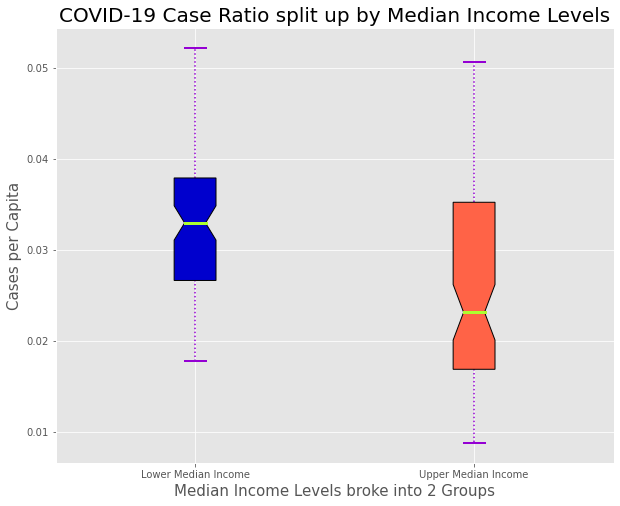

In [109]:
fig, ax = plt.subplots(figsize=(10,8))

data = [cases_lower['cases_per_capita'], cases_upper['cases_per_capita']]

flierprops = dict(marker='D', markerfacecolor='r', markersize=8,
              linestyle='none', markeredgecolor='g')
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True, notch='True', vert=1, flierprops=flierprops)


colors = ['mediumblue', 'tomato'] 
  
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 

# changing color and linewidth of whiskers 
for whisker in bp['whiskers']: 
    whisker.set(color ='darkviolet', 
                linewidth = 1.5, 
                linestyle =":") 
    
for cap in bp['caps']: 
    cap.set(color ='darkviolet', 
            linewidth = 2) 

for median in bp['medians']: 
    median.set(color ='greenyellow', 
               linewidth = 3) 

    
ax.set_title('COVID-19 Case Ratio split up by Median Income Levels', fontsize=20)
ax.set_ylabel('Cases per Capita', fontsize=15)
ax.set_xlabel('Median Income Levels broke into 2 Groups', fontsize=15)
ax.set_xticklabels(['Lower Median Income', 'Upper Median Income'])


ax.get_xaxis().tick_bottom() 
ax.get_yaxis().tick_left()

plt.savefig('../img/case_ratio_boxplot',  dpi=300)